<a href="https://colab.research.google.com/github/annvix/Accents_LSTM-/blob/master/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Клонирование проекта с GitHub
Подключение библиотек

In [2]:
!git clone https://github.com/annvix/Accents_LSTM-.git

fatal: destination path 'Accents_LSTM-' already exists and is not an empty directory.


In [3]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import random

from tensorflow.keras.models import Sequential

#from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from keras.layers import *
from keras.models import *
from keras.optimizers import *

from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing import sequence

Using TensorFlow backend.


# Загрузка и предобработка данных

Добавляем алфавит для кодирования букв

In [0]:
alphabet =   {'а' : 1, 'б' : 2, 'в' : 3, 'г' : 4, 'д' : 5, 'е' : 6, 'ё' : 7, 'ж' : 8, 'з' : 9,
             'и' : 10, 'й' : 11, 'к' : 12, 'л' : 13, 'м' : 14, 'н' : 15, 'о' : 16, 'п' : 17, 'р' : 18,
             'с' : 19, 'т' : 20, 'у' : 21, 'ф' : 22, 'х' : 23, 'ц' : 24, 'ч' : 25, 'ш' : 26, 'щ' : 27,
             'ъ' : 28, 'ы' : 29, 'ь' : 30, 'э' : 31, 'ю' : 32, 'я' : 33}

N = 10 #Количество слов для вывода

In [5]:
with open('Accents_LSTM-/Data.csv', 'r') as f:
    all_accents = f.readlines()
data_len = len(all_accents)

print('Всего слов:', data_len)
max_len = len(max(all_accents, key=len)) //2 - 1
print('Максимальная длина слова:', max_len)
print('Слово:', max(all_accents, key=len))
number_of_classes = max_len + 1

Всего слов: 1678878
Максимальная длина слова: 29
Слово: административнодисциплинарный,административнодисципл'инарный



Группировка слов по первым буквам

In [6]:
word_groups = []
group  = []
group.append(all_accents[0])

for i in range(1, data_len):
    if group[0][:4] == all_accents[i][:4]:
        group.append(all_accents[i])
    else:
        word_groups.append(group)
        group  = []
        group.append(all_accents[i])
print('Количество групп: ', len(word_groups))
random.shuffle(word_groups)

Количество групп:  42078


In [7]:
print('Группы слов:')
for i in range (N):
  print(word_groups[i])

Группы слов:
["хауэлл,х'ауэлл\n", "хауэр,х'ауэр\n", "хауэрд,х'ауэрд\n"]
["ютерт,ют'ерт\n"]
["повяжем,пов'яжем\n", "повяжемся,пов'яжемся\n", "повяжет,пов'яжет\n", "повяжете,пов'яжете\n", "повяжетесь,пов'яжетесь\n", "повяжется,пов'яжется\n", "повяжешь,пов'яжешь\n", "повяжешься,пов'яжешься\n", "повяжи,повяж'и\n", "повяжись,повяж'ись\n", "повяжите,повяж'ите\n", "повяжитесь,повяж'итесь\n", "повяжу,повяж'у\n", "повяжусь,повяж'усь\n", "повяжут,пов'яжут\n", "повяжутся,пов'яжутся\n", "повязавшая,повяз'авшая\n", "повязавшего,повяз'авшего\n", "повязавшее,повяз'авшее\n", "повязавшей,повяз'авшей\n", "повязавшем,повяз'авшем\n", "повязавшему,повяз'авшему\n", "повязавшею,повяз'авшею\n", "повязавшие,повяз'авшие\n", "повязавший,повяз'авший\n", "повязавшийся,повяз'авшийся\n", "повязавшим,повяз'авшим\n", "повязавшими,повяз'авшими\n", "повязавших,повяз'авших\n", "повязавшую,повяз'авшую\n", "повязал,повяз'ал\n", "повязала,повяз'ала\n", "повязалась,повяз'алась\n", "повязали,повяз'али\n", "повязались,повяз'ал

Разделим данные на тренировочные, валидационные и тестовые

In [0]:
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

def train_test_val_words(words):
    return (words[:int(len(words)*train_frac)], 
words[int(len(words)*train_frac) : (int(len(words)*train_frac) + int(len(words)*val_frac))], 
words[(int(len(words)*train_frac) + int(len(words)*val_frac)):])
    

for_train, for_val, for_test = train_test_val_words(word_groups)

In [0]:
def words_to_num(my_words):
  words, accents = [], []
  for i in range (len(my_words)):
      str = my_words[i].replace('\n', '').split(',')
      words.append(str[0])
      accents.append(str[1])

  words_int = np.zeros((len(my_words), number_of_classes), dtype=int)
  accents_int = np.zeros((len(my_words),number_of_classes), dtype=int)
  
  for i in range(len(words)):
    for j in range(len(words[i])):
        words_int[i][j]= alphabet[words[i][j]]
        
    acc = accents[i].find("'")
    if (acc != -1):
        accents_int[i][acc] = 1
        if accents[i][acc + 1:].find("'") != -1:
          print('В слове два ударения:', accents[i])
    else:
        accents_int[i][number_of_classes - 1] = 1
        print('Нет ударения: ', words[i])
  return words_int, accents_int

In [10]:
train_x, train_y= [], []
for i in range(len(for_train)):
  w, a = words_to_num(for_train[i])
  for j in range(len(for_train[i])):
    train_x.append(w[j])
    train_y.append(a[j])
  
val_x, val_y= [], []
for i in range(len(for_val)):
  w, a = words_to_num(for_val[i])
  for j in range(len(for_val[i])):
    val_x.append(w[j])
    val_y.append(a[j])

test_x, test_y= [], []
for i in range(len(for_test)):
  w, a = words_to_num(for_test[i])
  for j in range(len(for_test[i])):
    test_x.append(w[j])
    test_y.append(a[j])


Нет ударения:  ль
Нет ударения:  ж
Нет ударения:  тсс
Нет ударения:  б
Нет ударения:  в
Нет ударения:  кш
Нет ударения:  хм
Нет ударения:  с
Нет ударения:  гм
Нет ударения:  мм
Нет ударения:  к
Нет ударения:  брр
В слове два ударения обагр'я'ясь


In [0]:
test_x = np.array(test_x) 
train_x = np.array(train_x) 
val_x = np.array(val_x) 

test_y = np.array(test_y) 
train_y = np.array(train_y) 
val_y = np.array(val_y) 

In [12]:
print("\t\t\t Размеры:")
print("Train set: \t\t{}".format(test_x.shape), 
      "\nValidation set: \t{}".format(train_x.shape),
      "\nTest set: \t\t{}".format(val_x.shape))

			 Размеры:
Train set: 		(161675, 30) 
Validation set: 	(1347877, 30) 
Test set: 		(169325, 30)


# Моделирование нейронной сети
Используется LSTM-сеть

In [13]:
max_features = len(alphabet) + 1
max_features

34

In [0]:
from keras.models import *
from keras.optimizers import *

In [0]:
def unet(pretrained_weights = None,input_size = (number_of_classes, 1)):

    inputs = Input(input_size)

    conv1 = Conv1D(64, 2, activation = 'relu')(inputs)
    conv1 = Conv1D(64, 2, activation = 'relu')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(128, 2, activation = 'relu', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv1D(128, 2, activation = 'relu', kernel_initializer = 'he_normal')(conv2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(256, 2, activation = 'relu', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv1D(256, 2, activation = 'relu', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv2)

    up4 = Conv1D(128, 2, activation = 'relu', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(drop3))
    merge4 = concatenate([drop2,up4], axis = 1)
    conv4 = Conv1D(128, 2, activation = 'relu', kernel_initializer = 'he_normal')(merge4)
    conv4 = Conv1D(128, 2, activation = 'relu', kernel_initializer = 'he_normal')(conv4)

    up5 = Conv1D(64, 2, activation = 'relu', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv4))
    merge5 = concatenate([conv1,up5], axis = 1)
    conv5 = Conv1D(64, 2, activation = 'relu', kernel_initializer = 'he_normal')(merge5)
    conv5 = Conv1D(64, 2, activation = 'relu', kernel_initializer = 'he_normal')(conv5)
    conv5 = Conv1D(2, 2, activation = 'relu', kernel_initializer = 'he_normal')(conv5)
    conv6 = Conv1D(30, 90, activation = 'softmax')(conv5)
    
    model = Model(input = inputs, output = conv6)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    print(model.summary())

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [16]:
model = unet()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 29, 64)       192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 28, 64)       8256        conv1d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 14, 64)       0           conv1d_2[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [18]:
batch_size = 256 * 4
epochs = 20

X_train = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
Y_train = np.reshape(train_y, (train_y.shape[0], 1, train_y.shape[1]))

X_val =  np.reshape(val_x, (val_x.shape[0], val_x.shape[1], 1))
Y_val =  np.reshape(val_y, (val_y.shape[0], 1, val_y.shape[1]))

#model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)

history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, Y_val))

Train on 1347877 samples, validate on 169325 samples
Epoch 1/20
1347877/1347877 [==============================] - 1567s 1ms/step - loss: 1.7751 - accuracy: 0.3848 - val_loss: 1.4548 - val_accuracy: 0.5056
Epoch 2/20
1347877/1347877 [==============================] - 1560s 1ms/step - loss: 1.3635 - accuracy: 0.5291 - val_loss: 1.2838 - val_accuracy: 0.5632
Epoch 3/20
1347877/1347877 [==============================] - 1559s 1ms/step - loss: 1.2224 - accuracy: 0.5734 - val_loss: 1.1887 - val_accuracy: 0.5903
Epoch 4/20
1347877/1347877 [==============================] - 1565s 1ms/step - loss: 1.1414 - accuracy: 0.5973 - val_loss: 1.1344 - val_accuracy: 0.6060
Epoch 5/20
1347877/1347877 [==============================] - 1571s 1ms/step - loss: 1.0803 - accuracy: 0.6170 - val_loss: 1.0665 - val_accuracy: 0.6290
Epoch 6/20
1347877/1347877 [==============================] - 1564s 1ms/step - loss: 1.0299 - accuracy: 0.6342 - val_loss: 1.0265 - val_accuracy: 0.6418
Epoch 7/20
1347877/1347877 [=

Построим графики для точности и функции стоимости относительно эпох

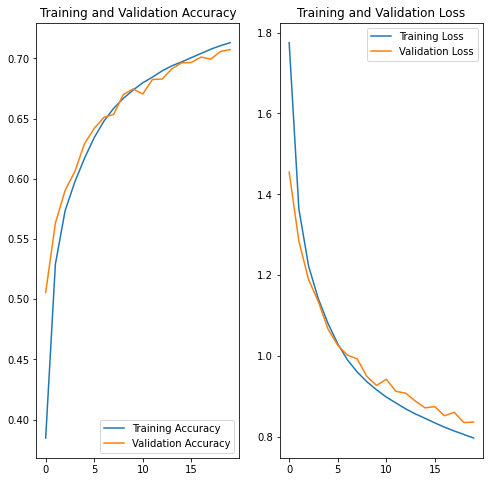

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Сохраним предобученную сеть

In [0]:
model.save('Accents_LSTM-/CNN_model.h5')

Сохраним датасет и предобученную сеть на компьютер

In [0]:
#files.download('Accents_LSTM-/Data.csv')
files.download('Accents_LSTM-/CNN_model.h5')

# Тесты на обученной модели

In [0]:
model = load_model('Accents_LSTM-/model.h5')

In [0]:
model.compile(optimizer='adam',
                  loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy'),
                  metrics=['accuracy'])

Предскажем позицию ударения для тестовых данных

In [0]:
X_test = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
Y_test = np.reshape(test_y, (test_y.shape[0], 1, test_y.shape[1]))

acc_pred = model.predict(X_test)

test_accur = 0
for i in range(len(acc_pred)):
    if acc_pred[i].argmax() == Y_test[i].argmax():
        test_accur = test_accur + 1
test_accur = test_accur/len(acc_pred)

In [0]:
print('Точность на тестовой выборке: ',test_accur)

Точность на тестовой выборке:  0.5280178338771949


Метод для возвращения ключа по значению

In [0]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

Визуализация предсказанных ударений и их сравнение с ответами

In [0]:
+for i in range(N):
    slovo = ''
    for j in range(len(X_test[i*100])):
        if X_test[i*100][j] != 0:
            slovo = slovo + get_key(alphabet, X_test[i*100][j])
        else:
            break
    template = slovo[:Y_test[i*100].argmax() + 1] + '\'' + slovo[Y_test[i*100].argmax() + 1:]
    nn_sample = slovo[:acc_pred[i*100].argmax() + 1] + '\'' + slovo[acc_pred[i*100].argmax() + 1:]
    
    if (acc_pred[i*100].argmax() != Y_test[i*100].argmax()):
      print('Эталон   : ' , template)
      print('Ошибка!  : ' , nn_sample)
    else:
      print('Результат: ' , nn_sample)
    print()

Результат:  каобердиа'но

Эталон   :  исхо'дной
Ошибка!  :  исход'ной

Эталон   :  зоопсихо'лог
Ошибка!  :  зоопси'холог

Результат:  пошевели'вшей

Результат:  поше'л

Результат:  пошепчи'сь

Эталон   :  кирзу'
Ошибка!  :  кирз'у

Результат:  ла'дит

Результат:  мозгля'вом

Результат:  этиотро'пном

